In [ ]:
# Import Libraries
import gc
import glob
import os
import random
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras import Model
from keras.activations import elu, softmax
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.core import Flatten
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
## Hypermeters & Constants
kaggleDir = '/kaggle/input/state-farm-distracted-driver-detection/'
train_img_dir = 'train/'
test_img_dir = 'test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 28
EPOCHS = 150  # Total Number of epoch

In [ ]:
# Set the seed value for repreducing the results
tf.set_random_seed(SEED_VAL)
gc.enable()
np.random.seed(SEED_VAL)
random.seed(SEED_VAL)

In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Exploratory Data Analysis
---
In this section, we will do the image data analysis for driver pose and behavior.


---
We have data in couple for file 
1. **CSV(driver_imgs_list) :** Contianing list of drivers and there activites images. 
1. **images (train, tes) :** These two directory is containing the drivers images. 

In [ ]:
## Load Data
df_train = pd.read_csv(kaggleDir + 'driver_imgs_list.csv', low_memory=True)
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

df_train = shuffle(df_train)

In this Section, I am using **glob** python pakage. Which is using python shell script to fill all the files path. On the bases of regex matches. 

Load all the images form directory and check the number of images per directory. 

In [ ]:
print("[INFO] : Load all the images.....")
trainImgDir = os.path.join(kaggleDir, train_img_dir)
testImgDir = os.path.join(kaggleDir, test_img_dir)
trainImgs = glob.glob(trainImgDir + '*/*.jpg')
testImgs = glob.glob(testImgDir + '*.jpg')
len(trainImgs), len(testImgs)

In [ ]:
for x in trainImgs:
    print(x)
    break

for x in testImgs:
    print(x)
    break

In [ ]:
# Display top five record in csv
df_train.head()

In [ ]:
# Dispaly Last five samples from CSV.
df_train.tail()

# BarPlot and PieChart
---
- A bar plot is a plot that presents categorical data with rectangular bars with lengths proportional to the values that they represent. A bar plot shows comparisons among discrete categories. One axis of the plot shows the specific categories being compared, and the other axis represents a measured value.4-

- A pie chart is a circular statistical diagram. The area of the whole chart represents 100% or the whole of the data. The areas of the pies present in the Pie chart represent the percentage of parts of data.  The area of the wedges determines the relative quantum or percentage of a part with respect to a whole. Pie charts are frequently used in business presentations as they give a quick summary of the business activities like sales, operations and so on.


Pie charts are also used heavily in survey results, news articles, resource usage diagrams like disk and memory. 

In [ ]:
class_freq_count = df_train.classname.value_counts()

class_freq_count.plot(kind='bar', label='index')
plt.title('Sample Per Class');
plt.show()

plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=CLASSES.values())
plt.title('Sample % per class');
plt.show()

Data is balanced 

In [ ]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
img = load_img(imgPath)
plt.suptitle(CLASSES['c6'])
plt.imshow(img)

In [ ]:
def draw_driver(imgs, df, classId='c0'):
    fig, axis = plt.subplots(2, 3, figsize=(20, 7))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(kaggleDir, train_img_dir, f"{classId}/{row['img']}")
        row = idnx // 3
        col = idnx % 3 
        img = load_img(imgPath)
        #         img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img)
        axis[row, col].imshow(img)
    plt.suptitle(CLASSES[classId])
    plt.show()

In [ ]:
draw_driver(df_train[df_train.classname == 'c0'].head(6), df_train, classId='c0')

In [ ]:
draw_driver(df_train[df_train.classname == 'c1'].head(6), df_train, classId='c1')

In [ ]:
draw_driver(df_train[df_train.classname == 'c2'].head(6), df_train, classId='c2')

In [ ]:
draw_driver(df_train[df_train.classname == 'c3'].head(6), df_train, classId='c3')

In [ ]:

draw_driver(df_train[df_train.classname == 'c4'].head(6), df_train, classId='c4')

In [ ]:
draw_driver(df_train[df_train.classname == 'c5'].head(6), df_train, classId='c5')

In [ ]:
draw_driver(df_train[df_train.classname == 'c6'].head(6), df_train, classId='c6')

In [ ]:
draw_driver(df_train[df_train.classname == 'c7'].head(6), df_train, classId='c7')

In [ ]:
draw_driver(df_train[df_train.classname == 'c8'].head(6), df_train, classId='c8')

In [ ]:
draw_driver(df_train[df_train.classname == 'c9'].head(6), df_train, classId='c9')

# Image Pre-Processing
---

In [ ]:
dfY = df_train.classname
x_train, x_test, y_train, y_test = train_test_split(df_train, dfY, test_size=0.15, stratify=dfY)
print('Number of Samples in XTrain : {} Ytrain: {}'.format(x_train.shape[0], y_train.shape[0]))
print('Number of Samples in Xtest : {} Ytest: {}'.format(x_test.shape[0], y_test.shape[0]))

In [ ]:
df_train.head()

In [ ]:
df_train['file_name']=df_train.img.apply(lambda  x:x[:-4])

In [ ]:
df_train.head()

In [ ]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        #         print("[INFO] : Simple PreProcessor invoked...!")
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        #         print("[INFO] : Prepossess Resizing invoked...!")
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)


In [ ]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        self.dataFormat = dataFormat

    def preprocess(self, image):
        return img_to_array(image, data_format=self.dataFormat)

In [ ]:
class SimpleDataLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, trainImgs, verbose=-1):
        imgData = []
        imgLabels = []
        for (idx, imgPath) in enumerate(trainImgs):
            tmpImg = cv2.imread(imgPath)
            classLabel = imgPath.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for preprocesor in self.preprocessors:
                    img = preprocesor.preprocess(tmpImg)
                    gc.collect()
                imgData.append(tmpImg)
                imgLabels.append(imgLabels)

            if verbose > 0 and idx > 0 and (idx + 1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format((idx + 1), len(trainImgs)))
        print(len(imgData), len(imgLabels))
        return np.array(imgData), np.array(imgLabels)

In [ ]:
print("[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!")
# sp=SimplePreprocessor(IMG_DIM,IMG_DIM)
# iap=ImageToArrayPreprocessor()
# loader=SimpleDataLoader(preprocessors=[sp,iap])
# (data,labels)=loader.load(trainImgs, verbose=5000)
# # Re-scale the image

In [ ]:
# data = data.astype('float') / 255.0
# xtrain,xtest,ytrain,ytest= train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
# print("[INFO] : Split dataset....!")
# labelBi = LabelBinarizer()
# trainY = labelBi.fit_transform(ytrain)
# testY = labelBi.fit_transform(ytest)

# Data Augmentation
----
-  Data Augmentation is the technique to generate new sample from the existing sample. So, you can reduce generalization error. It will genrerate natrual sample. There are number of features, which can help you in data agumentation. 

* **rotation_range :**  is a value in degrees (0-180), a range within which to randomly rotate pictures.
* **height_shift_range :**   Constructor control the amount of horizontal and vertical shift respectively.
* **width_shift_range :**  Constructor control the amount of horizontal and vertical shift respectively.
* **shear_range :** Shear Intensity (Shear angle in counter-clockwise direction in degrees)
* **zoom_range :** Range for random zoom
* **horizontal_flip :** Randomly filp of input image in horizontally. *But we can't use in our case.* It can chane the class of images.
* **fill_mode :** Points outside the boundaries of the input image are filled according to the given mode. (default Nearest)
 

In [ ]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
image=load_img(imgPath)
image=img_to_array(image)
image=np.expand_dims(image, axis=0)
generator = ImageDataGenerator(rotation_range=30,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
#                                horizontal_flip=True,
                               fill_mode='nearest') 
imageGen=generator.flow(image,batch_size=1)

In [ ]:
for i in range(6):
    nextImg=imageGen.next()
    plt.subplot(230 + 1 + i)
    image = nextImg[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
generator = ImageDataGenerator(rescale=1 / 255.0,
                               zoom_range=30,
                               samplewise_center=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2,
                               shear_range=0.2, 
                               fill_mode='nearest',
                               validation_split=0.15)

In [ ]:

train_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode="rgb",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='training')
valid_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode="rgb",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='validation')
train_generator.class_indices
gc.collect()

In [ ]:
train_generator.class_indices,valid_generator.samples

In [ ]:
trainImgs[:5]

# Keras Callbacks Functions
--- 
I can say callbacks function are helper functions. They will help you in understanding overfitting and underfitting at early stage, you don't need to wait till the end of train.  

They Returns training details loss, accuracy from algorithm, after each epoch and you can use that details to analysis you training after each iteration.
> **A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.**

Keras has multiple callback functions.  
* **BaseLogger and History :** By Default 
* **ModelCheckpoint :** Save the model best weights
* **EarlyStopping :** Stop training if it's not getting improve after defined epochs
* **ReduceLROnPlateau :** Reduce Learning Rate if  accuracy is not getting improve after defined epochs.

Here we are using 

**EarlyStopping** & **ReduceLROnPlateau**


**EarlyStopping:**  This is a callback function, which helps in handling the over-fitting. It can terminate the process of training for avoiding the over-fitting. It has number of parameters, those can help you, at which stage training need to be stopped.

* **monitor:** Specify the matrix for monitoring e.g val_loss, Val_acc etc
* **min_delta:** minimum change in the monitored value. For example, min_delta=1 means that the training process will be stopped if the absolute change of the monitored value is less than 1
* **patience:** Stop training if after specified epoch,if no improvement in loss or accuracy. 
* **mode:** It depend on monitor, e.g if you are monitoring loss it should be min and if you are monitoring accuracy it should be max. 

**ReduceLROnPlateau:** 
   It's for reducing the learning rate, if after specified epoch monitoring matrices(Val_loss, val_acc ) stopped improving. 

* **monitor:** quantity matrices to be monitored.
* **factor:** factor by which the learning rate will be reduced. new_lr = lr * factor
* **patience:** number of epochs with no improvement after which learning rate will be reduced.
* **min_lr:** lower bound on the learning rate.
* **min_delta:** threshold for measuring the new optimum, to only focus on significant changes.

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=8, verbose=1, min_delta=0.0000001)
reduceRL = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.001, min_delta=0.0001, verbose=1,
                             min_lr=1e-6)
callbacks = [reduceRL, earlyStop]

# Neural Network Architecture
---
Keras define neural network as sequence of layers. 
* **Sequential :**   Sequential API used for stacking the neural Network layers.



In [ ]:

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[IMG_DIM, IMG_DIM, 1], activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
# model.add(Activation(activation=elu))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(3000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(2000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(len(CLASSES)))
model.add(Activation(activation=softmax))
model.summary()

In [ ]:
# opt = SGD()#lr=0.0001
from keras.optimizers import adam
opt=adam()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])


In [ ]:
# History = model.fit_generator(train_generator,
#                               steps_per_epoch=train_generator.samples // BATCH_SIZE,
#                               validation_data=valid_generator,
#                               validation_steps=valid_generator.samples // BATCH_SIZE,
#                               epochs=EPOCHS,
#                               verbose=1).history  # , callbacks=callbacks

In [ ]:
# eval_loss, eval_acc = model.evaluate_generator(valid_generator, steps=valid_generator.samples / BATCH_SIZE);
# print('[INFO] : Evaluation Accuracy : {:.2f}%'.format(eval_acc * 100))
# print('[INFO] : Evaluation Loss : {}'.format(eval_loss))

# Training Accurcy / Loss 

In [ ]:
# History.keys()

In [ ]:
# plt.style.use('ggplot')
# plt.figure()
# plt.plot(np.arange(0, EPOCHS), History['acc'], label='Train_Acc')

# plt.plot(np.arange(0, EPOCHS), History['val_acc'], label='Valid_Acc')
# plt.plot(np.arange(0, EPOCHS), History['val_loss'], label='Valid_Loss')
# plt.plot(np.arange(0, EPOCHS), History['loss'], label='Train_Loss')
# plt.xlabel('Epochs#')
# plt.ylabel('Accuracy and Loss#')
# plt.title("Loss and Accuracy")
# plt.legend()
# plt.show()

# Transfer Learning

Transfer Learning is nothing it just using the existing pre-trained model and train on your data. 
Transfer Learning can be used two ways....
- Extract Features by passing samples to pre-train model
- Train model with your data from last layer and fine-tune hyperparameter

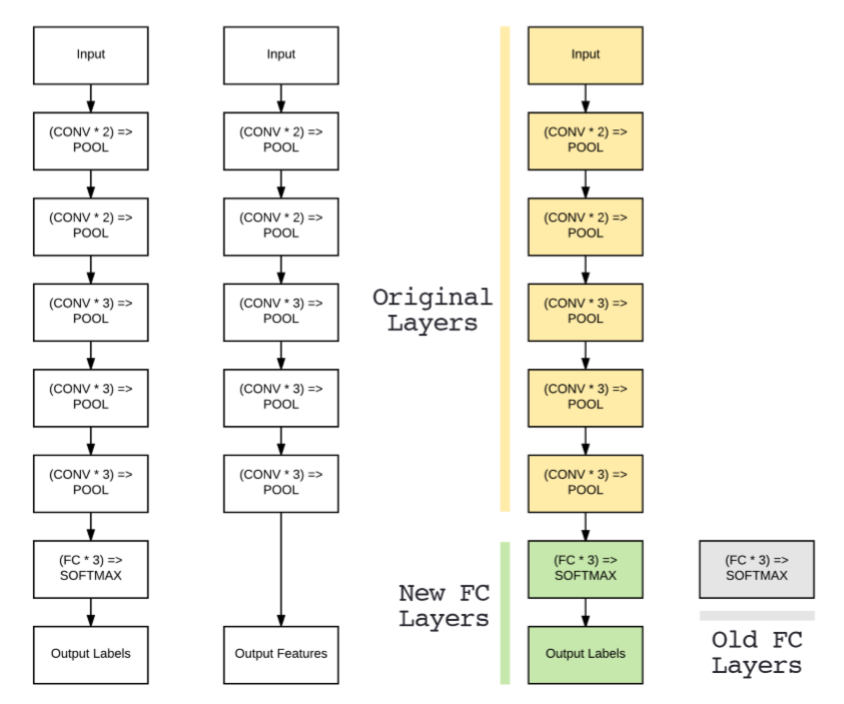

In [ ]:
class FCHeadNet:
    @staticmethod
    def build(baseModel, classes, D):
        # initialize the head model that will be placed on top of the base then ad a Fully Connected Layer
        headModel = baseModel.output
        headModel = Flatten(name='flatten')(headModel)
        headModel = Dense(D, activation='elu')(headModel)
        headModel = Dropout(0.2)(headModel) 

        # add Softmax Layer
        headModel = Dense(classes, activation='softmax')(headModel)

        # Return the model
        return headModel

In [ ]:
baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_DIM, IMG_DIM,3)))

In [ ]:
# initialize the new head of the network, a set of FC layers followed by a softmax classifier
headModel = FCHeadNet.build(baseModel, len(CLASSES), 10000)

In [ ]:
# place the head FC model on top of the base model -- this will become the actual model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model (this needs to be done after our setting our  layers to being non-trainable
print("[INFO] compiling model...")
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=['acc'])

# train the head  of the network for a  few epochs (all other layers are frozen) -- this will allow to the new FC
# layers to start to become initialized with actual  'learned ' values versus pure random


In [ ]:
model.summary()

In [ ]:
# loop over the layers in the network and display them to the console
for (idx, layer) in enumerate(model.layers):
    print('[INFO] : {} \t {}'.format(idx, layer.__class__.__name__))


In [ ]:
History = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples // BATCH_SIZE,
                              validation_data=valid_generator,
                              validation_steps=valid_generator.samples // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1 , callbacks=callbacks).history  #

In [ ]:
eval_loss, eval_acc = model.evaluate_generator(valid_generator, steps=valid_generator.samples / BATCH_SIZE);
print('[INFO] : Evaluation Accuracy : {:.2f}%'.format(eval_acc * 100))
print('[INFO] : Evaluation Loss : {}'.format(eval_loss))

In [ ]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), History['acc'], label='Train_Acc')

plt.plot(np.arange(0, EPOCHS), History['val_acc'], label='Valid_Acc')
plt.plot(np.arange(0, EPOCHS), History['val_loss'], label='Valid_Loss')
plt.plot(np.arange(0, EPOCHS), History['loss'], label='Train_Loss')
plt.xlabel('Epochs#')
plt.ylabel('Accuracy and Loss#')
plt.title("Loss and Accuracy")
plt.legend()
plt.show()

In [ ]:
from keras.applications import DenseNet201

model=DenseNet201(include_top=True, weights='imagenet')

* https://mc.ai/tutorial-on-keras-flow_from_dataframe/
* https://theailearner.com/2019/07/06/imagedatagenerator-flow_from_directory-method/
* https://pythontic.com/visualization/charts/piechart
* https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html
* https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/